We start by adding the necessary folders to the current working path.

In [1]:
# import sys/os
import sys, os

# get current directory
path = os.getcwd()

# get parent directory
parent_directory = os.path.sep.join(path.split(os.path.sep)[:-4])

# add utils folder to current working path
sys.path.append(parent_directory+"/subfunctions/utils")

# add integration folder to current working path
sys.path.append(parent_directory+"/subfunctions/integration")

# add 'FTLE3D' folder to current working path in order to access the functions
sys.path.append(parent_directory+"/demos/AdvectiveBarriers/FTLE3D")

# Overview

In the following notebook we compute the Finite Time Lyapunov Exponent ($ \mathrm{FTLE} $) on the three-dimensional, unsteady ABC-flow. This spatially periodic velocity field has been studied in several papers including [2,3,4,5]. As a benchmark we will use the unsteady version of the ABC-flow:

\begin{equation}
\begin{pmatrix} \dot{x}(t) \\ \dot{y}(t) \\ \dot{z}(t) \end{pmatrix} = \begin{pmatrix} u \\ v \\ w \end{pmatrix} = \begin{pmatrix} A\sin(z)+C\cos(y) \\ B\sin(x) + A\cos(z) \\ C\sin(y)+B\cos(x) \end{pmatrix}, \quad (x,y,z) \in [0, 2\pi]^3
\label{eq: periodicABC}.
\end{equation} 

The parameters are chosen to be: $ A = \sqrt{3}, B = \sqrt{2}, C = 1 $ and $ \nu = 0.025 $. The velocity-field is discretized with a spatial resolution of $ NX = NY = NZ = 51 $ and a temporal resolution of $ NT = 51 $. The time-interval is $ [0,20] $.

The velocity field is then discretized over the 3D meshgrid $ [0,2\pi]^3 $. The notebook is structured as follows:

1. Discretize unsteady ABC velocity field from analytical data.
<br />
2. Define computational parameters and data.
 <br />
3. Define spatio-temporal domain.
 <br />
4. Interpolate velocity from (discrete) gridded data.
 <br />
5. $ \mathrm{FTLE} $:

    * Compute gradient of flow map $ \mathbf{\nabla F}_{t_0}^{t_N}(\mathbf{x}_0) $ over meshgrid using an auxiliary grid.
     <br />
    * Compute $ \mathrm{FTLE} $ from maximum singular value $ \sigma_{max} $ of $ \mathbf{\nabla F}_{t_0}^{t_N}(\mathbf{x}_0) $ according to:
    \begin{equation}
    \mathrm{FTLE}_{t_0}^{t_N}(\mathbf{x}_0) = \dfrac{1}{t_N-t_0}\log(\sigma_{max}(\mathbf{x}_0))
    \end{equation}
 <br />
6. References

# Discretize velocity field from analytical data

We start by discretizing the velocity field from the unsteady ABC-flow.

In [2]:
# import scipy
import scipy.io

# import numpy
import numpy as np

def velocity_steady(A, B, C, x, y, z):
    
    u = A*np.sin(z)+C*np.cos(y)
    v = B*np.sin(x)+A*np.cos(z)
    w = C*np.sin(y)+B*np.cos(x)
    
    return u, v, w
            
def ABC_unsteady(nu, A, B, C, X, Y, Z, t):
    
    U = np.zeros((X.shape[0], Y.shape[1], Z.shape[2], t.shape[0]))
    V = np.zeros((X.shape[0], Y.shape[1], Z.shape[2], t.shape[0]))
    W = np.zeros((X.shape[0], Y.shape[1], Z.shape[2], t.shape[0]))             
                
    u, v, w = velocity_steady(A, B, C, X, Y, Z)
    
    for i in range(U.shape[-1]):
        U[:,:,:,i] = np.exp(-nu*t[i])*u
        V[:,:,:,i] = np.exp(-nu*t[i])*v
        W[:,:,:,i] = np.exp(-nu*t[i])*w
                    
    return U, V, W

# define grid of ABC flow
NX = 51
NY = NX
NZ = NY

x = np.linspace(0, 2*np.pi, 51, endpoint = True)
y = x.copy()
z = x.copy()
X, Y, Z = np.meshgrid(x, y, z)

# define constants of ABC flow
A = np.sqrt(3)
B = np.sqrt(2)
C = 1

# Define time interval
NT = 51

t0 = 0
tN = 20

time_data = np.linspace(t0, tN, NT, endpoint = True)

# We assume the same spatial resolution as in the steady ABC-flow

# viscosity
nu = 0.025

# compute velocity field for steady ABC flow
U, V, W = ABC_unsteady(nu, A, B, C, X, Y, Z, time_data)

time_data = time_data.reshape(1,-1)

# Computational parameters and data

Here we define the computational parameters and the data.

In [3]:
# import numpy
import numpy as np

# Number of cores for parallel computing
Ncores = 4 # int

# Periodic boundary conditions
periodic_x = True # bool
periodic_y = True # bool
periodic_z = True # bool
periodic = [periodic_x, periodic_y, periodic_z]

# Unsteady velocity field
bool_unsteady = True # bool

# Defined domain
defined_domain = np.isfinite(U).astype(int) # array (NY, NX, NZ)

## Compute meshgrid of dataset
X, Y, Z = np.meshgrid(x, y, z) # array (NY, NX), array (NY, NX, NZ)

## Resolution of meshgrid
dx_data = X[0,1,0]-X[0,0,0] # float
dy_data = Y[1,0,0]-Y[0,0,0] # float
dz_data = Y[0,0,1]-Z[0,0,0] # float

delta = [dx_data, dy_data, dx_data] # list (3, )

# Spatio-temporal domain

Here we define the spatio-temporal domain over which to consider the dynamical system.

In [4]:
# Initial time
t0 = 0 # float

# Final time
tN = 10 # float

# Time step-size
dt = 0.1 # float

time = np.arange(t0, tN+dt, dt) # shape (Nt,)

# Length of time interval
lenT = abs(tN-t0) # float

# boundaries
xmin = 0 # float
xmax = 2*np.pi # float
ymin = 0 # float
ymax = 2*np.pi # float
zmin = 0 # float
zmax = 2*np.pi # float

# Resolution of meshgrid
Ny = 200 # int
Nx = 200 # int
Nz = 200 # int

x_domain = np.linspace(xmin, xmax, Nx, endpoint = True) # array (Nx, )
y_domain = np.linspace(ymin, ymax, Ny, endpoint = True) # array (Ny, )
z_domain = np.linspace(zmin, zmax, Nz, endpoint = True) # array (Nz, )

dx = x_domain[1]-x_domain[0] # float
dy = y_domain[1]-y_domain[0] # float
dz = z_domain[1]-z_domain[0] # float

X_domain, Y_domain, Z_domain = np.meshgrid(x_domain, y_domain, z_domain) # array (Ny, Nx, Nz)

# auxiliary grid spacing
aux_grid = [0.1*dx, 0.1*dy, 0.1*dz] # list (3,)

# Interpolate velocity

In order to evaluate the velocity field at arbitrary locations, we interpolate the discrete velocity data. The interpolation with respect to time and space is linear.

In [5]:
# Import interpolation function for unsteady flow field
from ipynb.fs.defs.Interpolant import interpolant_unsteady

# Set nan values to zero (in case there are any) so that we can apply interpolant. 
# Interpolant does not work if the array contains nan values. 
U[np.isnan(U)] = 0
V[np.isnan(V)] = 0
W[np.isnan(W)] = 0

# Interpolate velocity data using cubic spatial interpolation
Interpolant = interpolant_unsteady(X, Y, Z, U, V, W, time_data)

Interpolant_u = Interpolant[0] # RectangularBivariateSpline-object
Interpolant_v = Interpolant[1] # RectangularBivariateSpline-object
Interpolant_w = Interpolant[2] # RectangularBivariateSpline-object

# FTLE

The computation of the $ \mathrm{FTLE} $ is not done over the 3D meshgrid but only over the 2D faces of the cube $ [0,2\pi]^3 $.
We iterate over all initial conditions on the faces of the cube and calculate the gradient of the flow map. From the maximum singular value of the gradient of the flow map we then compute the $ \mathrm{FTLE} $.

In [6]:
# Import function to compute gradient of flow map
from ipynb.fs.defs.gradient_flowmap import gradient_flowmap

# Import function to compute finite time Lyapunov exponent (FTLE)
from ipynb.fs.defs.FTLE import _FTLE

# Import package for parallel computing
from joblib import Parallel, delayed

def compute_FTLE(x0, y0, z0):
    
    X0 = np.array([x0, y0, z0]) # array (3, Nx*Ny*Nz)
    
    DF = gradient_flowmap(time, X0, X, Y, Z, Interpolant_u, Interpolant_v, Interpolant_w, periodic, bool_unsteady, aux_grid) # array (Nt, 3, 3, Nx*Ny*Nz)
    
    FTLE = []
    
    for i in range(DF.shape[3]):
        FTLE.append(_FTLE(DF[-1,:,:,i], lenT))
    
    return FTLE

# Split x0,y0,z0 into 'Ncores' equal batches for parallel computing
def split(a, n):
    k, m = divmod(len(a), n)
    return (a[i*k+min(i, m):(i+1)*k+min(i+1, m)] for i in range(n))

## XY-plane

Compute $ \mathrm{FTLE} $ over the 2D meshgrid on the XY-plane.

In [7]:
# Vectorize initial conditions by arranging them to a vector of size (Nx*Ny*Nz, )
x0_xy = X_domain[:,:,-1].ravel() # array (Nx*Ny, )
y0_xy = Y_domain[:,:,-1].ravel() # array (Nx*Ny, )
z0_xy = Z_domain[:,:,-1].ravel() # array (Nx*Ny, )

x0_batch = list(split(x0_xy, Ncores)) # list (Nx*Ny)
y0_batch = list(split(y0_xy, Ncores)) # list (Nx*Ny)
z0_batch = list(split(z0_xy, Ncores)) # list (Nx*Ny)
results = Parallel(n_jobs=Ncores, verbose = 2)(delayed(compute_FTLE)(x0_batch[i], y0_batch[i], z0_batch[i]) for i in range(len(x0_batch)))

# Extract results of FTLE computation on xy-plane
FTLE_xy = results[0]
for res in results[1:]:
    FTLE_xy = np.append(FTLE_xy, res)

# reshape vectorized arrays to structured array
X0_xy = np.array(x0_xy).reshape(Ny,Nx) # array (Ny, Nx)
Y0_xy = np.array(y0_xy).reshape(Ny,Nx) # array (Ny, Nx)
Z0_xy = np.array(z0_xy).reshape(Ny,Nx) # array (Ny, Nx)
FTLE_xy = np.array(FTLE_xy).reshape(Ny,Nx) # array (Ny, Nx)

[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done   2 out of   7 | elapsed:   34.3s remaining:  1.4min
[Parallel(n_jobs=7)]: Done   7 out of   7 | elapsed:   35.1s finished


## XZ-plane

Compute $ \mathrm{FTLE} $ over the 2D meshgrid on the XZ-plane.

In [8]:
# Vectorize initial conditions by arranging them to a vector of size (Nx*Ny*Nz, )
x0_xz = X_domain[0,:,:].ravel() # array (Nx*Nz, )
y0_xz = Y_domain[0,:,:].ravel() # array (Nx*Nz, )
z0_xz = Z_domain[0,:,:].ravel() # array (Nx*Nz, )

x0_batch = list(split(x0_xz, Ncores)) # list (Nx*Nz)
y0_batch = list(split(y0_xz, Ncores)) # list (Nx*Nz)
z0_batch = list(split(z0_xz, Ncores)) # list (Nx*Nz)
results = Parallel(n_jobs=Ncores, verbose = 2)(delayed(compute_FTLE)(x0_batch[i], y0_batch[i], z0_batch[i]) for i in range(len(x0_batch)))

# Extract results of FTLE computation on xz-plane
FTLE_xz = results[0]
for res in results[1:]:
    FTLE_xz = np.append(FTLE_xz, res)
    
# reshape vectorized arrays to structured array
X0_xz = np.array(x0_xz).reshape(Nz,Nx) # array (Nz, Nx)
Y0_xz = np.array(y0_xz).reshape(Nz,Nx) # array (Nz, Nx)
Z0_xz = np.array(z0_xz).reshape(Nz,Nx) # array (Nz, Nx)
FTLE_xz = np.array(FTLE_xz).reshape(Nz,Nx) # array (Nz, Nx)

[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done   2 out of   7 | elapsed:   32.7s remaining:  1.4min
[Parallel(n_jobs=7)]: Done   7 out of   7 | elapsed:   34.7s finished


## YZ-plane

Compute $ \mathrm{FTLE} $ over the 2D meshgrid on the YZ-plane.

In [9]:
# Vectorize initial conditions by arranging them to a vector of size (Nx*Ny*Nz, )
x0_yz = X_domain[:,0,:].ravel() # array (Nx*Ny*Nz, )
y0_yz = Y_domain[:,0,:].ravel() # array (Nx*Ny*Nz, )
z0_yz = Z_domain[:,0,:].ravel() # array (Nx*Ny*Nz, )

x0_batch = list(split(x0_yz, Ncores)) # list (Nx*Ny*Nz)
y0_batch = list(split(y0_yz, Ncores)) # list (Nx*Ny*Nz)
z0_batch = list(split(z0_yz, Ncores)) # list (Nx*Ny*Nz)
results = Parallel(n_jobs=Ncores, verbose = 2)(delayed(compute_FTLE)(x0_batch[i], y0_batch[i], z0_batch[i]) for i in range(len(x0_batch)))

# Extract results of FTLE computation on yz-plane
FTLE_yz = results[0]
for res in results[1:]:
    FTLE_yz = np.append(FTLE_yz, res)

# reshape vectorized arrays to structured array
X0_yz = np.array(x0_yz).reshape(Nz,Ny) # array (Nz, Ny)
Y0_yz = np.array(y0_yz).reshape(Nz,Ny) # array (Nz, Ny)
Z0_yz = np.array(z0_yz).reshape(Nz,Ny) # array (Nz, Ny)
FTLE_yz = np.array(FTLE_yz).reshape(Nz,Ny) # array (Nz, Ny)

[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done   2 out of   7 | elapsed:   30.0s remaining:  1.3min
[Parallel(n_jobs=7)]: Done   7 out of   7 | elapsed:   31.3s finished


In [ ]:
# Import plotly for 3D figures
from plotly import graph_objs as go

# define minimum and maximum values for colorbar
min_value = min(np.min(FTLE_yz),min(np.min(FTLE_xy), np.min(FTLE_xz)))
max_value = max(np.max(FTLE_yz),max(np.max(FTLE_xy), np.max(FTLE_xz)))

# create figure
fig = go.Figure(data=[go.Surface(x = X0_xy, y = Y0_xy, z = Z0_xy, surfacecolor = FTLE_xy, showscale = True, colorscale='rainbow', cmin=min_value, cmax=max_value)])
fig.add_trace(go.Surface(x = X0_xz, y = Y0_xz, z = Z0_xz, surfacecolor = FTLE_xz, showscale = False, colorscale='rainbow', cmin=min_value, cmax=max_value))
fig.add_trace(go.Surface(x = X0_yz, y = Y0_yz, z = Z0_yz, surfacecolor = FTLE_yz, showscale = False, colorscale='rainbow', cmin=min_value, cmax=max_value))
fig.add_trace(go.Surface(x = X0_xy, y = Y0_xy, z = Z0_xy-2*np.pi, surfacecolor = FTLE_xy, showscale = False, colorscale='rainbow', cmin=min_value, cmax=max_value))
fig.add_trace(go.Surface(x = X0_xz, y = Y0_xz+2*np.pi, z = Z0_xz, surfacecolor = FTLE_xz, showscale = False, colorscale='rainbow', cmin=min_value, cmax=max_value))
fig.add_trace(go.Surface(x = X0_yz+2*np.pi, y = Y0_yz, z = Z0_yz, surfacecolor = FTLE_yz, showscale = False, colorscale='rainbow', cmin=min_value, cmax=max_value))

# camera
camera = dict(eye=dict(x=-1.45,y=-1.45,z=1.7))
fig.update_layout(scene_camera=camera)

fig.update_layout(
    title={
        'text': f'$\mathrm{{FTLE}}_{t0}^{{{tN}}}$',
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})

fig.show()

Ridges of the forward $ \mathrm{FTLE} $-field indicate repelling coherent structures.

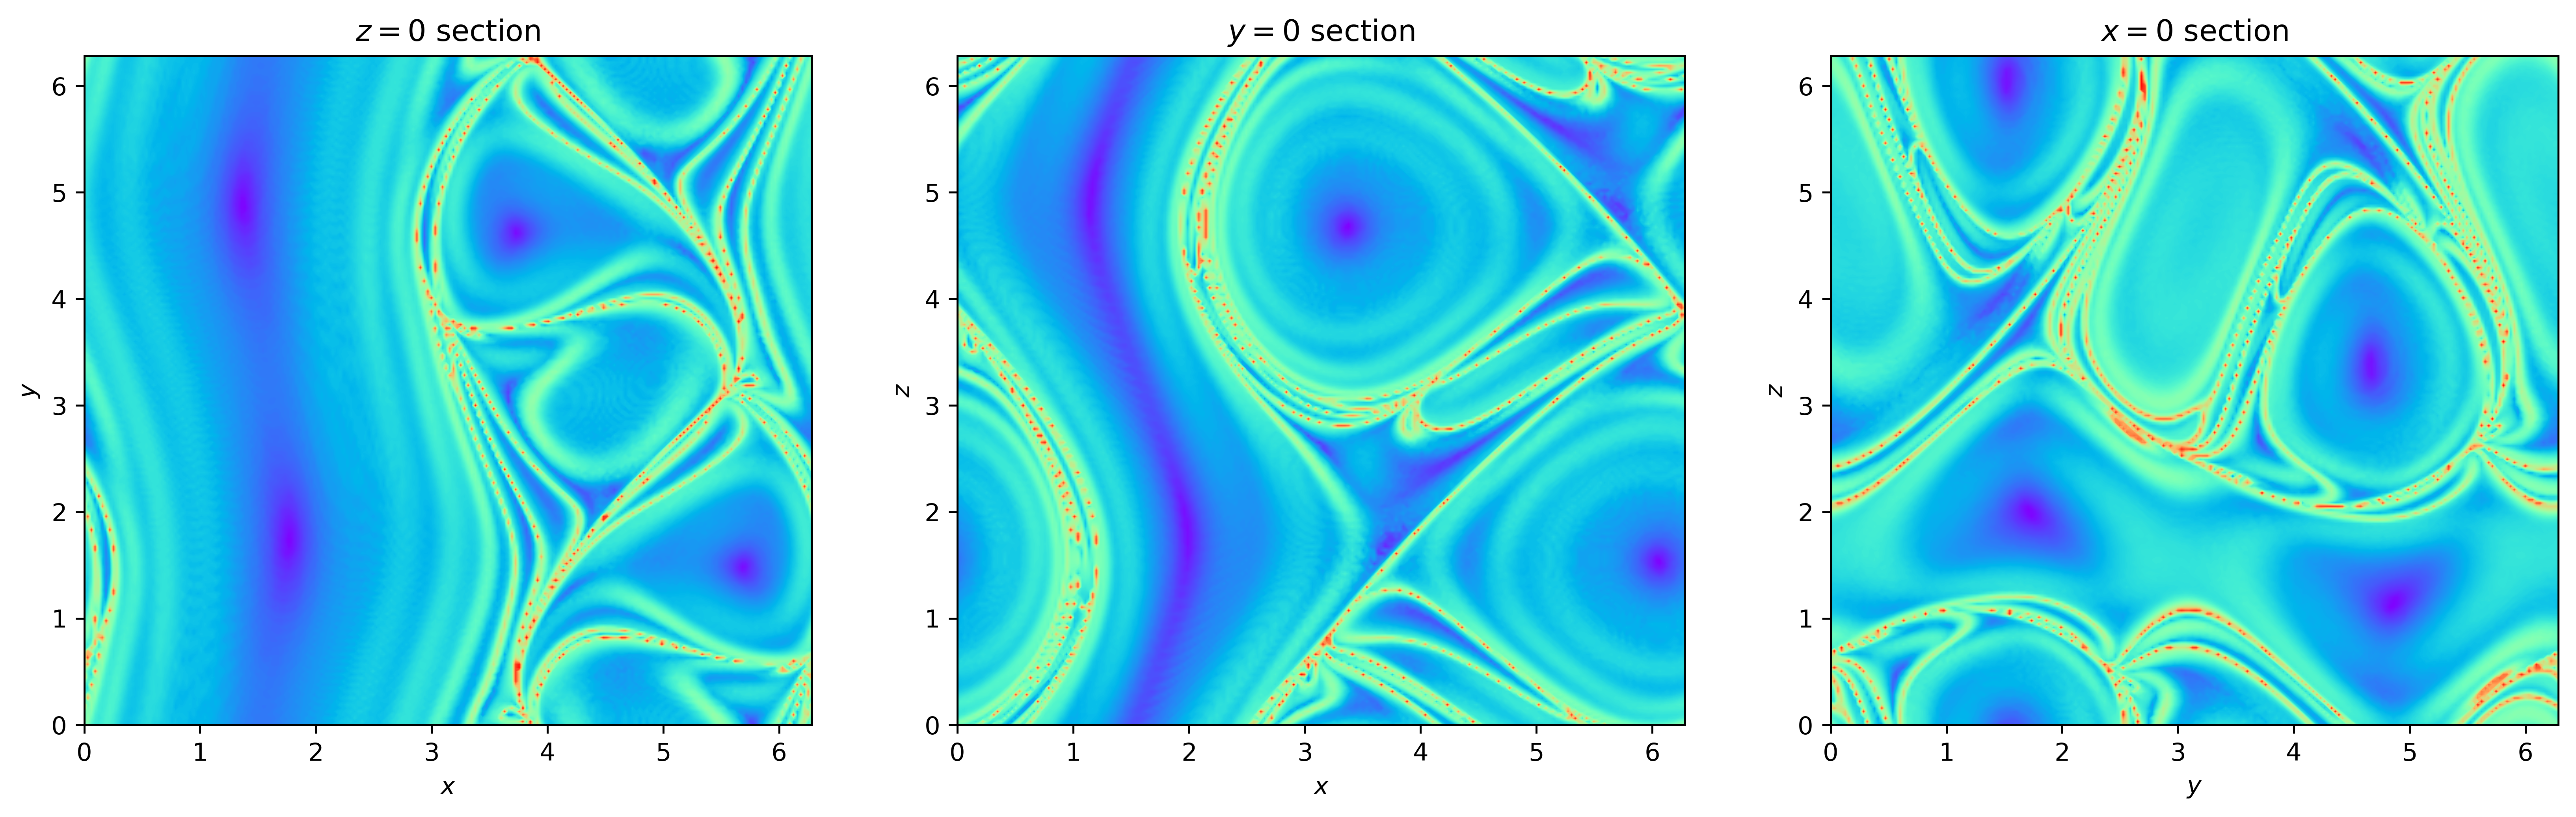

In [11]:
# import matplotlib
import matplotlib.pyplot as plt

f,axes = plt.subplots(ncols = 3, nrows = 1, figsize = (18, 5), dpi = 450)
cmapToUse = 'rainbow'
nContours = 600

axes[0].contourf(x_domain, y_domain, FTLE_xy, levels = nContours,  cmap = cmapToUse)
axes[0].set_xlabel('$x$')
axes[0].set_ylabel('$y$')
axes[0].set_title('$z=0$ section')

axes[1].contourf(x_domain, z_domain, FTLE_xz, levels = nContours,  cmap = cmapToUse)
axes[1].set_xlabel('$x$')
axes[1].set_ylabel('$z$')
axes[1].set_title('$y=0$ section')

axes[2].contourf(y_domain, z_domain, FTLE_yz, levels = nContours,  cmap = cmapToUse)
axes[2].set_xlabel('$y$')
axes[2].set_ylabel('$z$')
axes[2].set_title('$x=0$ section')

plt.show()

# References

[1] Haller, G. (2001). Distinguished material surfaces and coherent structures in three-dimensional fluid flows. Physica D: Nonlinear Phenomena, 149(4), 248-277.

[2] Dombre, T., Frisch, U., Greene, J. M., Hénon, M., Mehr, A., & Soward, A. M. (1986). Chaotic streamlines in the ABC flows. Journal of Fluid Mechanics, 167, 353-391.

[3] Haller, G. (2001). Distinguished material surfaces and coherent structures in three-dimensional fluid flows. Physica D: Nonlinear Phenomena, 149(4), 248-277.

[4] Oettinger, D., & Haller, G. (2016). An autonomous dynamical system captures all LCSs in three-dimensional unsteady flows. Chaos: An Interdisciplinary Journal of Nonlinear Science, 26(10), 103111.

[5] Haller, G., Aksamit, N., & Encinas-Bartos, A. P. (2021). Quasi-objective coherent structure diagnostics from single trajectories. Chaos: An Interdisciplinary Journal of Nonlinear Science, 31(4), 043131.

[6] Notebook 5.2.4. in "Transport Barriers and Coherent Structures in Flow Data" by Prof. George Haller.